# Obligatorio
<h3><i>Machine learning</i> para Inteligencia Artificial</h3>

**Autores:**
- Germán Otero, N° de estudiante: 138796
- Sebastián Uriarte Güimil, N° de estudiante: 194973

**Nota:** La versión más reciente de este obligatorio, así como de los laboratorios/tareas
anteriores, se encuentran disponibles en
[este repositorio](https://github.com/sebassu/machine-learning-para-IA).

## 1. Introducción

El presente obligatorio, entregable final del curso, tiene como objetivo la aplicación
de los distintos conceptos, técnicas y modelos vistos como parte del contenido de la
materia, al análisis de un caso real. En particular, en esta ocasión el problema a
abordar es uno de clasificación de imágenes, en el marco de detección de rostros.

<img style="float: right; margin: 0px 0px 5px 10px" src="assets/haar_like_features.jpg">

La mayoría de las técnicas modernas para el procesamiento de imágenes involucran modelos
más complejos, como por ejemplo las populares redes neuronales convolucionales. Sin
embargo, también es posible obtener buenos resultados mediante agentes más sencillos,
que requerirán menores recursos computacionales. Para ello, una implementación posible
será simplemente iterando sobre toda ventana de la imagen original y ejecutando un
modelo que retorne si esta subimagen es la de un rostro o no, debiendo este clasificador
ser particularmente performante dado el gran número de llamadas se realizarán. Es en
este último aspecto que se centrará el presente trabajo.

En su _paper_ titulado "_Rapid Object Detection Using a Boosted Cascade of Simple
Features_", los autores Viola y Jones proponen el uso de las llamadas
**_Haar-like features_**. Brevemente, estas son funciones que transforman la imagen en
un valor numérico, resultante de la suma o resta de regiones rectangulares de
pixeles en escala de grises. Cada _feature_ tiene un identificador que define el número,
tamaño y coordenadas de estas regiones. Ejemplos de la mismas se muestran en la figura
presentada.

En esta tarea se utilizarán estas, obtenidas a partir de un _dataset_ de imagenes de
rostros y fondos, para entrenar modelos de _machine learning_ que las clasifiquen en
estas dos categorías. El objetivo final será subir estos resultados a la
[competencia de Kaggle](https://www.kaggle.com/competitions/obligatorio-mlia-2024)
asociada con el obligatorio.

## 2. Carga y transformación de datos
En esta sección, se reutilizó y adaptó gran parte del código presentado en clase;
particularmente, aquél vinculado al laboratorio 2.

Para este obligatorio fue entregado un nuevo _dataset_, obtenible en
[este enlace](https://www.kaggle.com/competitions/obligatorio-mlia-2024/data). Dado que
su descarga requiere autenticación al estar bajo una competencia privada, se asume este
archivo `.zip` que contiene los datos fue descargado y se encuentra en la misma ruta que
esta _notebook_.

In [17]:
from glob import glob
from os.path import basename, exists
from os import makedirs
from matplotlib.pyplot import imread
from skimage.transform import resize
from skimage.io import imsave
from shutil import rmtree
from skimage import data
from random import seed, shuffle
from itertools import chain
import numpy as np
from skimage.color import rgb2gray
from sklearn.feature_extraction.image import PatchExtractor

In [ ]:
SEED = 42
seed(SEED)
np.random.seed(SEED)

In [9]:
!unzip -oq ./obligatorio-mlia-2024.zip -d ./data
!mv ./data/Faces/Faces/*.pgm ./data/Train/Original_Faces
!mv ./data/Test/Test/*.pgm ./data/Test
!rm -rf ./data/Faces
!rm -rf ./data/Test/Test

### 2.1 Escalado de imágenes
Una primera obseservación (algo obvia) que surge es que, a diferencia del laboratorio 2,
las imágenes bajo `/Test` no están etiquetadas las categorías `Face` y `Non-face`. Esto
resulta evidente puesto que esto es el resultado a determinar para la competencia en
Kaggle.

Otro punto a considerar es que, también a diferencia  del laboratorio 2, las imágenes de
rostros dentro de `Train` tienen tamaño `64 x 64`, mientras que las de `Test` son de
`19 x 19`. Esto se considera puede discrepancias entre el proceso de entrenamiento y la
posterior evaluación, al generar la salida a subirse a Kaggle.

Si bien las _features_ a generarse toman una ventana limitada de la imagen para calcular
el valor asociado, potencialmente a partir de imágenes de tamaño `64 x 64` sería posible
calcular _features_ que, por su tamaño o coordenadas, en una de `19 x 19` no se podría
(que, por ejemplo, se encontrarían por fuera de la imagen o excederían su tamaño).
Puesto entonces que estaríamos entranando al modelo con información luego no disponible
en `Test`, lo cual representa un problema. Por esto, se resuelve escalar las imágenes de
`Train` al tamaño de las de `Test`, `19 x 19`, de la siguiente forma:

In [16]:
SOURCE_PATH, OUTPUT_PATH = "./data/Train/Original_Faces", "./data/Train/Faces"
if exists(OUTPUT_PATH):
    rmtree(OUTPUT_PATH)
makedirs(OUTPUT_PATH)

for path in glob(f"{SOURCE_PATH}/*.pgm"):
    image = resize(image=imread(path), output_shape=(19, 19))
    imsave(f"{OUTPUT_PATH}/{basename(path)}", image)
rmtree(SOURCE_PATH)
del SOURCE_PATH, OUTPUT_PATH

### 2.2 Generación de imágenes de fondos
Una segunda inconveniencia que tiene el _dataset_ de este obligatorio es que, a
diferencia del anterior, las imágenes de `Train` consisten únicamente de rostros. Por
tanto, será necesario generar imágenes de fondos para poder entrenar apropiadamente los
modelos a obtenerse. Para ello se utilizará la estrategia presentada en _notebooks_ en 
Aulas, y las imágenes de
[_Backgrounds_](https://aulas.ort.edu.uy/mod/resource/view.php?id=517711); en escencia
generando recortes de tamaño `19 x 19` de imágenes que no contienen rostros. A esto
agregaremos también las imágenes del _dataset_ del laboratorio 2, tanto para rostros
como para no rostros, que podemos reutilizar para este.

Un punto a discutir es el número total de imágenes a generar. Dado que el clasificador a
entrenarse sería utilizado con un detector que haría llamadas con ventanas arbitrarias
de una imagen dada, donde habría a lo sumo unos pocos rostros frente a una cantidad
mucho mayor de ventanas, resulta razonable tener una cantidad muy superior de fondos
frente a rostros. Para el laboratorio 2, se tenía que:

<div style="margin: auto; width: 50%">

| **_Data Set_**    | **_Faces_**  |  **_Non-faces_**  |
|:-----------------:|:------------:|:-----------------:|
| **_Train_**       |    2429      |    4548           |
| **_Test_**        |    472       |    23573          |

</div>

Donde se observa que hay mucho mayor cantidad de imágenes `Non-face` (fondos) que `Face`
(rostros) en ambos `Train` y `Test`. Para no generar una cantidad considerada excesiva
(50 veces más, que dado que hay )

In [18]:
background_image_names = [
    "binary_blobs",
    "brick",
    "colorwheel",
    "cat",
    "checkerboard",
    "clock",
    "coffee",
    "coins",
    "grass",
    "gravel",
    "horse",
    "logo",
    "page",
    "text",
    "rocket",
]


def is_rgb(image: np.ndarray) -> bool:
    return len(image.shape) == 3 and image.shape[2] == 3


skimage_background_images = (getattr(data, name)() for name in background_image_names)
custom_background_images = (imread(path) for path in glob("./assets/Background/*.jpg"))
raw_background_images = [
    rgb2gray(image) if is_rgb(image) else image
    for image in chain(skimage_background_images, custom_background_images)
]
shuffle(raw_background_images)

extractor = PatchExtractor(patch_size=(19, 19), max_patches=1, random_state=SEED)
patches = extractor.transform(images)

SyntaxError: expected argument value expression (2942498577.py, line 32)

## Librerías

In [1]:
import os
import random
from time import time

import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import equalize_hist
from skimage.feature import haar_like_feature, haar_like_feature_coord
from skimage.transform import integral_image
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tqdm import tqdm

## Funciones auxiliares

In [17]:
def extract_feature_image(img, feature_type=None, feature_coord=None):
    ii = integral_image(img)
    return haar_like_feature(
        ii,
        0,
        0,
        ii.shape[0],
        ii.shape[1],
        feature_type=feature_type,
        feature_coord=feature_coord,
    )

## Datos

**CBCL FACE DATABASE #1**:
*   19 x 19 Grayscale PGM format images
*   Training set:  2429 faces, 4548 non-faces
*   Test set: 472 faces, 23573 non-faces

In [19]:
suffix = ".pgm"

train_faces = os.listdir("./train/face")
train_faces = [filename for filename in train_faces if filename.endswith(suffix)]

train_background = os.listdir("./train/non-face")
train_background = [
    filename for filename in train_background if filename.endswith(suffix)
]

test_faces = os.listdir("./test/face")
test_faces = [filename for filename in test_faces if filename.endswith(suffix)]

test_background = os.listdir("./test/non-face")
test_background = [
    filename for filename in test_background if filename.endswith(suffix)
]

In [20]:
print(f"# Train Faces: {len(train_faces)}")
print(f"# Train Back: {len(train_background)}")
print(f"# Test Faces: {len(test_faces)}")
print(f"# Test Back: {len(test_background)}")

# Train Faces: 2429
# Train Back: 4548
# Test Faces: 472
# Test Back: 23573


In [21]:
# Tomaremos una fracción de los datos. Puede ajustar estos parámetros a gusto
f = 0.05
n_face = int(f * len(train_faces))
n_back = int(f * len(train_background))

# Para mantener la proporción de background en test calculamos:
m = int(np.round(len(test_faces) * len(train_background) / len(train_faces)))

print(f"# Train Faces Sample Size: {n_face}")
print(f"# Train Back Sample Size: {n_back}")
print(f"# m: {m}")

# Train Faces Sample Size: 121
# Train Back Sample Size: 227
# m: 884


In [22]:
sample_train_faces = random.sample(train_faces, n_face)

Im_train = []
for filename in tqdm(sample_train_faces):
    path = f"./train/face/{filename}"
    with open(path, "rb") as pgmf:
        image = plt.imread(pgmf)
    Im_train.append(image)

n_train_faces = len(Im_train)
y_train = [1] * n_train_faces

100%|██████████| 121/121 [00:00<00:00, 3592.77it/s]


In [23]:
sample_train_background = random.sample(train_background, n_back)

for filename in tqdm(sample_train_background):
    path = f"./train/non-face/{filename}"
    with open(path, "rb") as pgmf:
        image = plt.imread(pgmf)
    Im_train.append(image)

n_train_background = len(Im_train) - n_train_faces
y_train = y_train + [0] * n_train_background

100%|██████████| 227/227 [00:00<00:00, 3692.80it/s]


In [24]:
print(f"# Train: {len(Im_train)}, {len(y_train)}")

# Train: 348, 348


In [25]:
Im_test = []
for filename in tqdm(test_faces):
    path = "./test/face/" + filename
    with open(path, "rb") as pgmf:
        image = plt.imread(pgmf)
    Im_test.append(image)

n_test_faces = len(Im_test)
y_test = [1] * n_test_faces

100%|██████████| 472/472 [00:00<00:00, 2265.00it/s]


In [26]:
sample_test_background = random.sample(test_background, m)

for filename in tqdm(sample_test_background):
    path = "./test/non-face/" + filename
    with open(path, "rb") as pgmf:
        image = plt.imread(pgmf)
    Im_test.append(image)

n_test_background = len(Im_test) - n_test_faces
y_test = y_test + [0] * n_test_background

100%|██████████| 884/884 [00:00<00:00, 1930.86it/s]


In [27]:
print(f"# Test: {len(Im_test)}, {len(y_test)}")

# Test: 1356, 1356


## Histogram equalization

In [28]:
Im_train_norm = [equalize_hist(image) for image in Im_train]
Im_test_norm = [equalize_hist(image) for image in Im_test]

## Matriz de _features_

Calculamos y seleccionamos las mejores _features_ en entrenamiento

In [29]:
X_train = [extract_feature_image(img) for img in tqdm(Im_train_norm)]
X_train = np.array(X_train)
X_train.shape

100%|██████████| 348/348 [01:04<00:00,  5.38it/s]


(348, 63960)

In [30]:
print("Seleccionando las features de mayor dependencia lineal con y")
t_start = time()
f_indices = (
    SelectPercentile(f_classif, percentile=1)
    .fit(X_train, y_train)
    .get_support(indices=True)
)
t = time() - t_start
X_train = X_train[:, f_indices]
print("Seleccionadas %d features potenciales" % X_train.shape[1])
print(f"Tiempo: {t} segundos")

Seleccionando las features de mayor dependencia lineal con y
Seleccionadas 640 features potenciales
Tiempo: 0.7125539779663086 segundos


### Calculamos dichas features para test

In [31]:
feature_coord, feature_type = haar_like_feature_coord(
    width=19,
    height=19,
)

In [32]:
t_start = time()
X_test = [
    extract_feature_image(
        img,
        feature_type=feature_type[f_indices],
        feature_coord=feature_coord[f_indices],
    )
    for img in tqdm(Im_test_norm)
]
t = time() - t_start
X_test = np.array(X_test)

100%|██████████| 1356/1356 [00:01<00:00, 968.71it/s] 


In [33]:
print(f'Tiempo: {t} segundos')
print(f'Shape X_test: {X_test.shape}')

Tiempo: 1.4038243293762207 segundos
Shape X_test: (1356, 640)


___

## Entrenamiento de modelos

La propuesta del presente laboratorio 2 pide entrenar (al menos) un modelo que permita
abordar el problema de clasificación de imágenes en rostros y no rostros, en función de
las _features_ obtenidas en celdas anteriores. Para ello, podemos considerar lo
siguiente:

In [34]:
def test_model_with(model, parameters: dict):
    search = GridSearchCV(model, parameters, scoring="f1", cv=5)
    search.fit(X_train, y_train)
    print(f"Best params: {search.best_params_}")
    print(f"Best score: {search.best_score_}")

    y_pred = search.best_estimator_.predict(X_test)
    print(f"Accuracy score: {accuracy_score(y_test, y_pred)}\n")
    print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}\n")
    print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
    return search.best_estimator_

### _Decision Tree_

Best params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score: 0.9025180937087802
Accuracy score: 0.7971976401179941

Confusion Matrix:
 [[805  79]
 [196 276]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85       884
           1       0.78      0.58      0.67       472

    accuracy                           0.80      1356
   macro avg       0.79      0.75      0.76      1356
weighted avg       0.79      0.80      0.79      1356



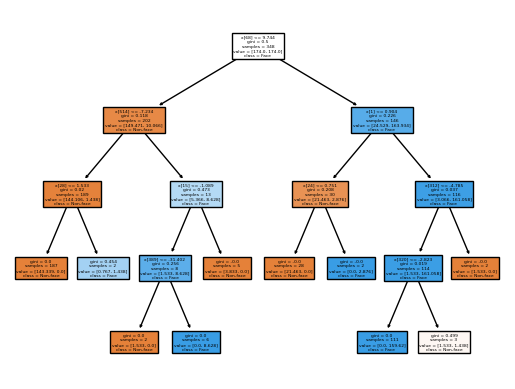

In [35]:
model = DecisionTreeClassifier()
parameters = {
    "criterion": ["gini", "log_loss"],
    "max_depth": [None, 5],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [2, 4, 6],
    "class_weight": ["balanced"],
}

best_decision_tree = test_model_with(model, parameters)
plot_tree(
    best_decision_tree,
    filled=True,
    class_names=["Non-face", "Face"],
)
plt.show()

### _Random Forest_

In [36]:
model = RandomForestClassifier()
parameters = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 10],
    "min_samples_split": [2, 6],
    "min_samples_leaf": [1, 4],
    "class_weight": ["balanced"],
}

best_random_forest = test_model_with(model, parameters)

Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best score: 0.9348292064980217
Accuracy score: 0.7912979351032449

Confusion Matrix:
 [[847  37]
 [246 226]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86       884
           1       0.86      0.48      0.61       472

    accuracy                           0.79      1356
   macro avg       0.82      0.72      0.74      1356
weighted avg       0.80      0.79      0.77      1356



### _Gradient Boosting_

In [19]:
model = GradientBoostingClassifier()
parameters = {
    "learning_rate": [0.2, 0.1, 0.05],
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [3, 5, 10],
}

best_gradient_boosting = test_model_with(model, parameters)

NameError: name 'GradientBoostingClassifier' is not defined

# Red neuronal

A continuación, realizamos diferentes pruebas con redes neuronales para evaluar la performance de otros modelos para tener como referencia.
